## Portfolio Optimization

In [14]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-dark-palette') 
import yfinance as yf 

import warnings 
warnings.filterwarnings('ignore') 

In [4]:
start_date = '2015-01-01' 
end_date = '2020-12-30' 
assets = ['AMD','NFLX','AAPL','GOOG'] 

In [5]:
weights = np.array([0.25,0.25,0.25,0.25]) 

In [7]:
df = pd.DataFrame() 
for tick in assets:
    df[f'{tick}_AdjClose'] = yf.download(tick,start=start_date,end=end_date)['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [8]:
df.head() 

,AMD_AdjClose,NFLX_AdjClose,AAPL_AdjClose,GOOG_AdjClose
Date,,,,
2015-01-02,2.67,49.848572,24.402168,26.138908
2015-01-05,2.66,47.311428,23.714724,25.594027
2015-01-06,2.63,46.501431,23.716953,25.000832
2015-01-07,2.58,46.742859,24.049522,24.958000
2015-01-08,2.61,47.779999,24.973560,25.036694


In [9]:
df.shape 

(1509, 4)

#### Visualizing the stock/portfolio

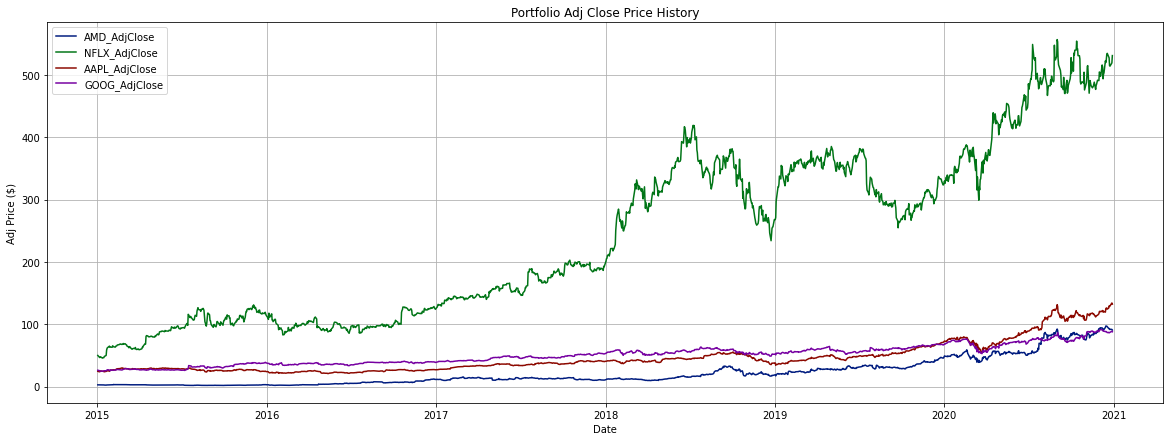

In [16]:
plt.figure(figsize=(20,7)) 

for c in df.columns.values:
    plt.plot(df[c],label=c) 

plt.title('Portfolio Adj Close Price History') 
plt.xlabel('Date')
plt.ylabel('Adj Price ($)') 
plt.legend(loc='best') 
plt.grid(True) 
plt.show() 

Calculating Daily Simple Returns

In [19]:
returns = df.pct_change() 
returns.dropna(inplace=True)  
returns.head()  

,AMD_AdjClose,NFLX_AdjClose,AAPL_AdjClose,GOOG_AdjClose
Date,,,,
2015-01-05,-0.003745,-0.050897,-0.028171,-0.020846
2015-01-06,-0.011278,-0.017121,0.000094,-0.023177
2015-01-07,-0.019011,0.005192,0.014022,-0.001713
2015-01-08,0.011628,0.022188,0.038422,0.003153
2015-01-09,0.007663,-0.015458,0.001072,-0.012951


Annualized Covariance Matrix

In [20]:
cov_matrix_annual = returns.cov()*252 
cov_matrix_annual 

,AMD_AdjClose,NFLX_AdjClose,AAPL_AdjClose,GOOG_AdjClose
AMD_AdjClose,0.405700,0.080967,0.069934,0.052781
NFLX_AdjClose,0.080967,0.180300,0.051894,0.054547
AAPL_AdjClose,0.069934,0.051894,0.087893,0.048425
GOOG_AdjClose,0.052781,0.054547,0.048425,0.072561


Calculate Portfolio Variance

In [21]:
port_variance = np.dot(weights.T,np.dot(cov_matrix_annual,weights)) 
port_variance 

0.09147191414638874

Calculate portfolio volatility aka Standard Deviation

In [22]:
port_volatility = np.sqrt(port_variance) 
port_volatility 

0.3024432411980614

Calculate annual portfolio return

In [23]:
port_simple_annual_return = np.sum(returns.mean()*weights)*252
port_simple_annual_return 

0.4589991558316737

In [24]:
percent_var = str(round(port_variance,2)*100)+'%'
percent_volatility = str(round(port_volatility,2)*100)+'%'
percent_ret = str(round(port_simple_annual_return,2)*100)+'%'

print('Expected annual returns : ',percent_ret)
print('Annual volatility/risk : ',percent_volatility)
print('Annual variance : ',percent_var) 

Expected annual returns :  46.0%
Annual volatility/risk :  30.0%
Annual variance :  9.0%


In [29]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting 
# plt.style.use('seaborn-v0_8-dark-palette') 

### Portfolio Optimization

Calculate the expected returns and annualized sample covariance matrix of asset returns

In [30]:
mu = expected_returns.mean_historical_return(df) 
S = risk_models.sample_cov(df) 

Optimize for maximum Sharpe Ratio

In [31]:
ef = EfficientFrontier(mu,S,weight_bounds=(None,None)) 
ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3] == 1) 
weights = ef.max_sharpe() 
cleaned_weights = ef.clean_weights() 
print(cleaned_weights) 
ef.portfolio_performance(verbose=True) 

OrderedDict([('AMD_AdjClose', 0.32954), ('NFLX_AdjClose', 0.39062), ('AAPL_AdjClose', 0.41638), ('GOOG_AdjClose', -0.13655)])
Expected annual return: 55.9%
Annual volatility: 35.9%
Sharpe Ratio: 1.50


(0.5589105139117052, 0.35917183245655404, 1.5004253263008664)

### Get the discrete allocation of each share per stock

In [33]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(df) 
weights = cleaned_weights 
da = DiscreteAllocation(weights,latest_prices,total_portfolio_value=50000) 
allocation,leftover = da.lp_portfolio() 
print('Discrete Allocation : ',allocation) 
print(f'Funds reamining : {leftover:.2f} $') 

Discrete Allocation :  {'AMD_AdjClose': 160, 'NFLX_AdjClose': 32, 'AAPL_AdjClose': 139, 'GOOG_AdjClose': -77}
Funds reamining : 203.90 $


### Portfolio Optimization

Calculate expected returns and annualized sample covariance matrix of asset returns

OrderedDict([('AMD_AdjClose', 1.0), ('NFLX_AdjClose', 0.99936), ('AAPL_AdjClose', 0.00064), ('GOOG_AdjClose', -1.0)])
Expected annual return: 106.2%
Annual volatility: 77.8%
Sharpe Ratio: 1.34


(1.0623845051911949, 0.7782459872750981, 1.3394023512295063)

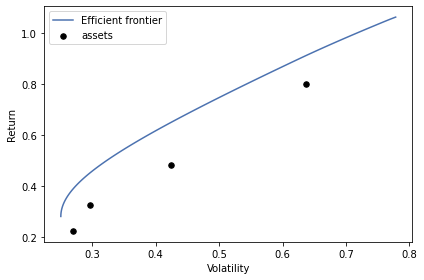

In [36]:
mu = expected_returns.mean_historical_return(df) 
S = risk_models.sample_cov(df) 

# Optimize for maximum sharpe ratio
ef = EfficientFrontier(mu,S,weight_bounds=(None,None)) 
ef.add_constraint(lambda w:w[0]+w[1]+w[2]+w[3]==1) 
plotting.plot_efficient_frontier(ef) 
# weights = ef.max_sharpe() 
cleaned_weights = ef.clean_weights() 
print(cleaned_weights) 
ef.portfolio_performance(verbose=True) 

Calculating the expected returns and the annualized sample covariance matrix of asset returns

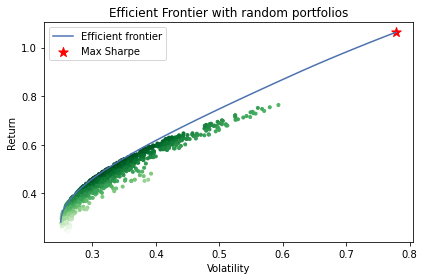

In [40]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

ef = EfficientFrontier(mu,S,weight_bounds=(None,None))
ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3] == 1)

fig,ax = plt.subplots() 
plotting.plot_efficient_frontier(ef,ax=ax,show_assets=False) 

# Find tangency portfolio
# ef.max_sharpe() 
ret_tangent, std_tangent,_ = ef.portfolio_performance() 
ax.scatter(std_tangent, ret_tangent, marker='*',s=100,c='r',label='Max Sharpe') 

# Generate random portfolios 
n_samples = 1000
w = np.random.dirichlet(np.ones(len(mu)),n_samples) 
rets = w.dot(mu) 
stds = np.sqrt(np.diag(w @ S @ w.T)) 
sharpes = rets/stds 
ax.scatter(stds, rets, marker='.',c=sharpes,cmap='Greens')

# Output 
ax.set_title('Efficient Frontier with random portfolios')
ax.legend() 
plt.tight_layout()
plt.show() 